# Мэтчинг товаров

Задача - разработать алгоритм, который подберет для каждого товара по пять наиболее похожих товаров.

### Подключение библиотек

In [1]:
!pip install faiss-cpu==1.7.4

In [2]:
!pip install jupyternotify

In [3]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [4]:
import pandas as pd
import numpy as np
import faiss

# Графики
import seaborn as sns
import matplotlib.pyplot as plt

# Обработка предупреждений
import warnings

# Подготовка данных
from sklearn.model_selection import train_test_split

# Время
from time import time


In [5]:
faiss.__version__

'1.7.4'

### Сеттинги

In [6]:
# Отображение датафреймов
pd.set_option('display.max_columns', None)

In [7]:
# Игнор предупреждений
warnings.filterwarnings('ignore')

In [8]:
# Графики
plt.style.use('fivethirtyeight')
plt.figure(figsize=(40,10))

<Figure size 4000x1000 with 0 Axes>

<Figure size 4000x1000 with 0 Axes>

### Константы

In [9]:
STATE = 111

## Подготовка данных

### Обзор данных

In [10]:
data_train = pd.read_csv('train.csv', index_col=0)
data_base = pd.read_csv('base.csv', index_col=0)
data_val = pd.read_csv('validation.csv', index_col=0)
data_val_ans = pd.read_csv('validation_answer.csv', index_col=0)

In [11]:
display(data_base.head())
print()
data_base.info()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,-124.06151,-32.458237,-57.420560,36.207405,182.71677,-28.071688,-5.209374,-1.732182,-91.09186,-79.46667,-103.939090,1507.231274,-32.591667,51.414360,-51.905360,813.770071,-41.556538,8.419807,-129.976640,148.76503,-10.069234,-143.00504,79.848694,-537.183707,2.773180,111.518680,4.257666,-153.34058,-123.62608,-39.707664,-12.768708,-4.170106,-152.967130,75.911520,-57.470088,17.266476,-98.871155,-138.06754,91.000380,-170.702000,-50.020390,59.794296,78.106380,-89.375725,89.412100,79.812180,-129.51361,-44.659496,-80.44221,5.149714,-64.518950,-138.77763,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,-141.30435,-126.768900,-68.853530,8.314717,143.08174,8.778257,15.157185,48.246360,-244.95486,-80.27942,-81.788040,429.880035,-5.937690,70.142654,66.576840,813.770071,3.214371,17.164303,-39.418385,148.15588,-7.579590,-174.36995,101.224630,-303.939233,16.914630,53.394676,33.451824,-148.55263,-110.34017,-33.277206,-8.688703,13.650302,-91.228745,38.445015,-31.948470,62.484820,-166.473360,-189.01042,-56.731556,-30.027319,59.171060,-56.711540,63.542606,-121.319170,97.426056,74.832840,-138.77705,58.887608,-71.59534,-251.952358,11.392853,-148.57166,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,-140.82245,-22.486748,-51.666990,2.521726,140.58545,-22.039230,-7.128634,-5.184787,-111.71212,-79.02927,-82.452576,1507.231274,-0.421011,84.108010,63.344510,813.770071,-105.211050,18.844700,-94.789474,151.38771,-21.483440,-144.84537,48.502934,-780.449185,64.767310,79.781555,-13.390142,-150.06166,-118.75855,-40.896286,-15.222620,-1.860338,-93.820656,98.749070,-46.745782,65.927475,-10.286392,-125.32137,21.048609,-22.637775,68.915985,-54.902260,66.335470,-142.927920,83.030980,69.979630,-123.73389,65.320880,-114.03718,-529.396956,-101.581375,-134.65822,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,-108.47044,-104.537780,-82.388490,-79.986740,113.59631,-38.995880,-4.787360,8.327808,-124.85576,-79.10902,-107.943275,1479.170530,-125.271614,24.656485,-16.921055,813.770071,-182.680270,14.715704,-62.932700,151.20198,10.613454,-134.93434,58.777730,-529.295053,43.665924,92.806305,-38.936657,-145.04530,-124.29577,-36.876730,-17.742870,10.536242,-124.584150,121.914150,-17.321358,105.217240,-94.379650,-63.76927,29.217487,-26.423973,5.869829,64.061550,63.513280,-112.258100,80.926590,72.636100,-137.31432,7.912551,-62.18892,-540.321044,-89.588715,-149.32669,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,-110.34245,-38.982060,-50.228867,-26.690920,135.27290,-7.510103,8.924209,111.576950,-130.83319,-79.31585,-57.843952,1262.919738,19.225910,59.811813,76.159670,312.698903,-76.726974,21.299923,-24.069107,167.38553,-44.059470,-148.13185,98.042610,-657.524388,96.363170,71.061520,-36.563557,-135.37244,-123.70898,-44.739437,-10.855220,8.354800,-168.328860,215.928070,-32.975979,66.864880,30.838630,-211.54037,57.695343,-67.822630,-29.389133,-34.123740,54.710550,-26.032013,90.673910,58.086998,-134.78206,77.62


<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64

<div class="alert alert-secondary" role="alert">
<b>Заметка:</b>
<br> 
Так как base включает в себя как train-выборку, так и validation-выборку, то предварительному обзору подвергаем только base.
    
В данных присутствует 71 абстрактный признак с вещественными значениями и таргет - типа object.
    

</div>

In [12]:
data_train.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71',
       'Target'],
      dtype='object')

In [13]:
data_base.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71'],
      dtype='object')

In [14]:
data_val.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71'],
      dtype='object')

In [15]:
data_val_ans.columns

Index(['Expected'], dtype='object')

### Пропуски

In [16]:
print('Количество пропусков в base:', data_base.isna().sum(), '\n')
print('Количество пропусков в train:', data_train.isna().sum(), '\n')
print('Количество пропусков в validation:', data_val.isna().sum(), '\n')

Количество пропусков в base: 0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64 

Количество пропусков в train: 0         0
1         0
2         0
3         0
4         0
         ..
68        0
69        0
70        0
71        0
Target    0
Length: 73, dtype: int64 

Количество пропусков в validation: 0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64 



<div class="alert alert-secondary" role="alert">
<b>Заметка:</b>
<br> 
Во всех дф отсутствуют пропуски.
</div>

### Дубликаты

In [17]:
print('Количество дубликатов в base:', data_base.duplicated().sum(), '\n')
print('Количество дубликатов в train:', data_train.duplicated().sum(), '\n')
print('Количество дубликатов в validation:', data_val.duplicated().sum(), '\n')

Количество дубликатов в base: 0 

Количество дубликатов в train: 0 

Количество дубликатов в validation: 0 



<div class="alert alert-secondary" role="alert">
<b>Заметка:</b>
<br> 
Ни в одном из dataframe нет дубликатов
</div>

### Выбросы

In [18]:
data, data_base_obv = train_test_split(data_base, test_size=0.1, random_state=STATE)
data_base_obv.shape

(291814, 72)

Text(0, 0.5, 'Значение признака')

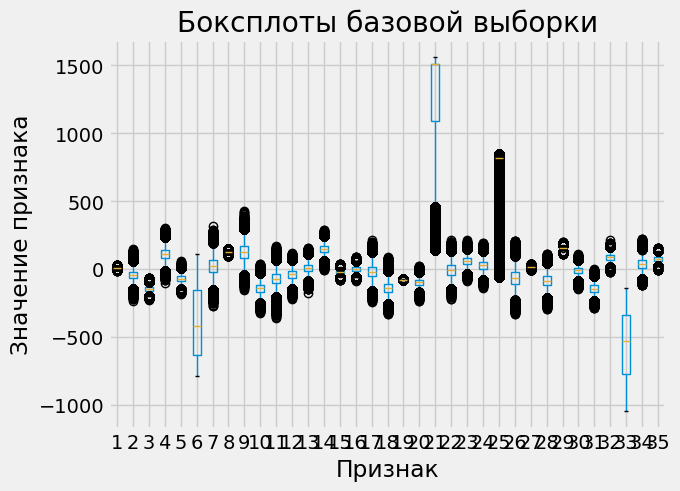

<IPython.core.display.Javascript object>

In [19]:
%%notify
data_base_obv.iloc[:, 1:36].boxplot();
plt.title('Боксплоты базовой выборки');
plt.xlabel('Признак');
plt.ylabel('Значение признака');

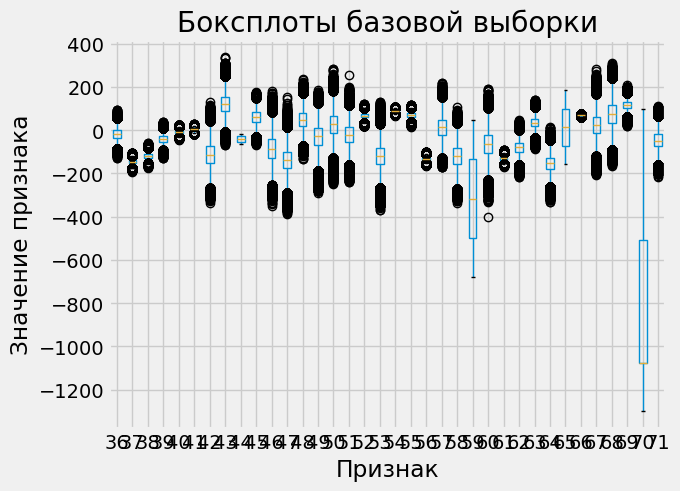

In [20]:
data_base_obv.iloc[:, 36:].boxplot();
plt.title('Боксплоты базовой выборки');
plt.xlabel('Признак');
plt.ylabel('Значение признака');

<div class="alert alert-secondary" role="alert">
<b>Заметка:</b>
<br> 
У каждого из признаков есть большое количество выбросов
</div>

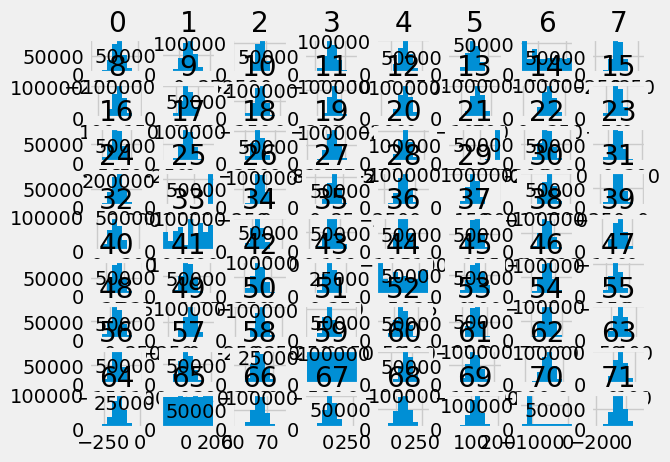

In [21]:
data_base_obv.hist();

### Мультиколлинеарность

In [22]:
(data_base_obv.corr() > 0.7).sum().sum()

72

<div class="alert alert-secondary" role="alert">
<b>Заметка:</b>
<br> 
Значения корреляции, превышающей 0,7, составляют 72 штуки, то есть это корреляцией с самими собой, а между другими признаками сильной корреляции нет.
</div>

### Метрика

In [23]:
base_index = {k: v for k, v in enumerate(data_base.index.to_list())}

In [24]:
def acc_5(D, I, targets):
    acc = 0
    for target, el in zip(targets.values.tolist(), I.tolist()):
        acc += int(target in [base_index[D] for D in el])
    return 100*acc/len(I)

## Обучение моделей

In [25]:
dim = data_base.shape[1]
k = 5
nlist = 1000

In [26]:
quantizer = faiss.IndexFlatL2(dim)

In [27]:
index = faiss.IndexIVFFlat(quantizer, dim, nlist)

<div class="alert alert-secondary" role="alert">
<b>Заметка:</b>
<br> 
Начиная с этого момента, мой компьютер перестает обрабатывать код. Просто показывает, что ячейка обрабатывается, но за десять часов никакого результата. Плюсы - я познакомилась с документацией faiss, довольно интересно. Минусы - как бы я ни шаманила, все стоит: ни ошибки, ни корректной обработки
</div>

In [ ]:
%%notify
index.train(np.ascontiguousarray(data_base.values[:40000, :]).astype('float32'))

In [ ]:
%%notify
index.add(np.ascontiguousarray(data_base.values).astype('float32'))

In [ ]:
index.ntotal

In [ ]:
%%notify

start = time()
D, I = index.search(np.ascontiguousarray(data_val.values).astype('float32'), k)
end = time()

round((end-start)/60, 3)

In [ ]:
print('Accuracy@5 =', acc_5(D, I, data_val_ans))